# LendingClub Loan Data Analysis and Machine Learning Project
---
---
- Author: Christopher Carney
- Year: 2020
- License: MIT

## The Data:
This data (LendingClub loan data) is originally from Kaggle: https://www.kaggle.com/wordsforthewise/lending-club

It was then edited by Jose Marcial Portilla (Pierian Data Inc.) to add more feature engineering opportunities as part of the capstone project.

## The Goal:
Given historical data on loans given out with information on whether or not the borrower defaulted (charge-off), can we build a model that can predict wether or nor a borrower will pay back their loan? This way in the future when we get a new potential customer we can assess whether or not they are likely to pay back the loan. Keep in mind classification metrics when evaluating the performance of your model!

The "loan_status" column contains our label, and then is changed to "loan_paid" for ease of use once converted to ints.

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping

%matplotlib inline

In [2]:
data_info = pd.read_csv('data/lending_club_info.csv', index_col='LoanStatNew')

In [3]:
df = pd.read_csv('data/lending_club_loan_two.csv')

In [4]:
def get_desc(feature):
    '''This method takes a feature name and returns its description.
    Ex:
    >> get_desc('loan_amnt')
    loan_amnt: The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
    '''
    print(f'{feature}: {data_info["Description"][feature]}')

get_desc('loan_amnt')

loan_amnt: The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.


---
# Exploratory Data Analysis and Data Cleansing
---

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394275 non-null  object 
 15  

In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
loan_amnt,396030.0,14113.888089,8357.441341,500.00,8000.00,12000.00,20000.00,40000.00
int_rate,396030.0,13.639400,4.472157,5.32,10.49,13.33,16.49,30.99
installment,396030.0,431.849698,250.727790,16.08,250.33,375.43,567.30,1533.81
annual_inc,396030.0,74203.175798,61637.621158,0.00,45000.00,64000.00,90000.00,8706582.00
dti,396030.0,17.379514,18.019092,0.00,11.28,16.91,22.98,9999.00
open_acc,396030.0,11.311153,5.137649,0.00,8.00,10.00,14.00,90.00
pub_rec,396030.0,0.178191,0.530671,0.00,0.00,0.00,0.00,86.00
revol_bal,396030.0,15844.539853,20591.836109,0.00,6025.00,11181.00,19620.00,1743266.00
revol_util,395754.0,53.791749,24.452193,0.00,35.80,54.80,72.90,892.30
total_acc,396030.0,25.414744,11.886991,2.00,17.00,24.00,32.00,151.00


In [7]:
df[df.columns[df.isnull().sum() > 0]].isnull().sum()

emp_title               22927
emp_length              18301
title                    1755
revol_util                276
mort_acc                37795
pub_rec_bankruptcies      535
dtype: int64

<AxesSubplot:xlabel='loan_status', ylabel='count'>

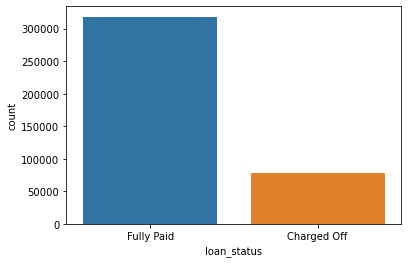

In [8]:
sns.countplot(data=df, x='loan_status')

Many more loans are paid than not paid.  This will be important to consider when looking at the different measures of accuracy for our Machine Learning model.

<AxesSubplot:xlabel='loan_amnt'>

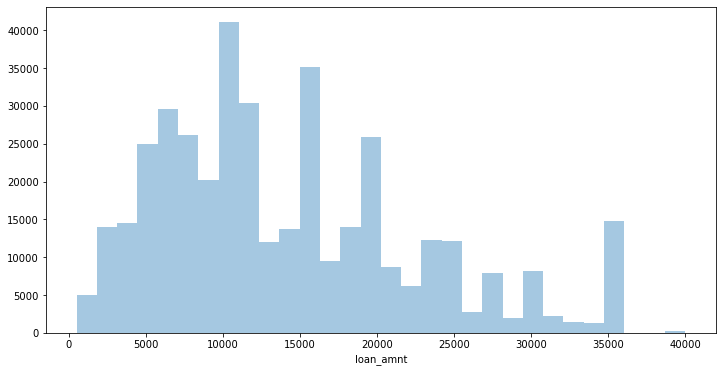

In [9]:
plt.figure(figsize=(12,6))
sns.distplot(df['loan_amnt'], kde=False, bins=30)

This is clearly not a normal distribution.  It is right skewed, and has certain 'popular' loan amounts.

<AxesSubplot:xlabel='loan_status', ylabel='loan_amnt'>

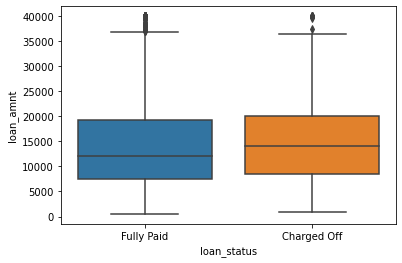

In [10]:
sns.boxplot(data=df, x='loan_status', y='loan_amnt')

The size of the loan does not seem to indicate the likelihood of failing to pay off the loan.

In [11]:
df['loan_paid'] = pd.get_dummies(df['loan_status'], drop_first=True)
df.drop('loan_status', axis=1, inplace=True)

In [12]:
loan_paid_df = pd.DataFrame({'LoanStatNew': ['loan_paid'], 'Description': ['1 if the loan is paid in full, 0 if "Charged Off"']})
data_info = data_info.reset_index().append(loan_paid_df).set_index('LoanStatNew')
data_info.drop('loan_status', inplace=True)

In [13]:
df['term'] = df['term'].apply(lambda x: int(x.split()[0]))

<AxesSubplot:xlabel='term', ylabel='count'>

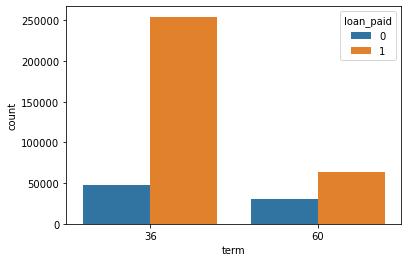

In [14]:
sns.countplot(data=df, x='term', hue='loan_paid')

The likelihood of not paying off the loan increases when the term is longer.  This will be a feature that we want to use in our algorithm.

<AxesSubplot:xlabel='grade', ylabel='count'>

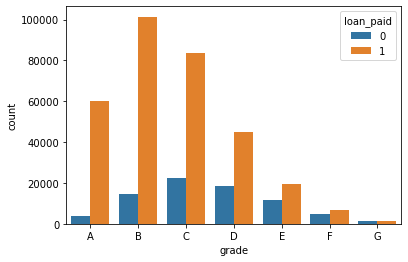

In [15]:
sns.countplot(data=df, x='grade', hue='loan_paid', order=list('ABCDEFG'))

The likelihood of not paying the loan increases as the grade decreases.

<AxesSubplot:xlabel='sub_grade', ylabel='count'>

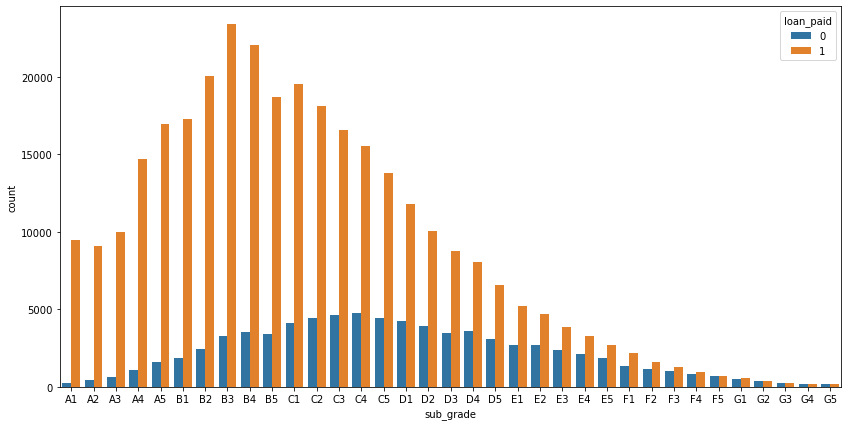

In [16]:
plt.figure(figsize=(14,7))
sns.countplot(data=df, x='sub_grade', hue='loan_paid', order=np.sort(df['sub_grade'].unique()))

This is very similar in shape to what is seen in the 'grade' feature.  We do see that the likelihood of not paying the loan in full increases for each subclass as well, which should give us increased accuracy.  Since this is a more detailed version of the 'grade' feature, I think it would be best to remove 'grade', to reduce redundency.

In [17]:
df = df.join(pd.get_dummies(df['sub_grade'].apply(lambda x: x.lower()), prefix='sg', drop_first=True))
df.drop('sub_grade', axis=1, inplace=True)
df.drop('grade', axis=1, inplace=True)

In [18]:
print(f'emp_title nunique: {df["emp_title"].nunique()}')
df.drop('emp_title', axis=1, inplace=True)

emp_title nunique: 173105


The 'emp_title' feature won't be useful to us as is, since there are so many unique values and no clear order.  If needed, we could come back to this and search for keywords within that could yield insights, such as 'junior', 'assistant', 'manager', etc.  This is not an issue that seems to be needed at this stage though.  For now, it will be removed.

In [19]:
# This plot doesn't show anything useful, and the next plot shows the same information more clearly.
# This is being done to prevent the file from becoming to large to work with.
'''
plt.figure(figsize=(14,7))
sns.countplot(data=df, x='emp_length', hue='loan_paid', order=['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years'])
'''

"\nplt.figure(figsize=(14,7))\nsns.countplot(data=df, x='emp_length', hue='loan_paid', order=['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years'])\n"

It doesn't seem like there is an obvious trend when it comes to employment tenure and liklihood of paying the loan.  Let's see if percentages of paid vs not paid for each year of employment length shows us anything valuable.

Text(0, 0.5, 'Fraction Charge-Offs')

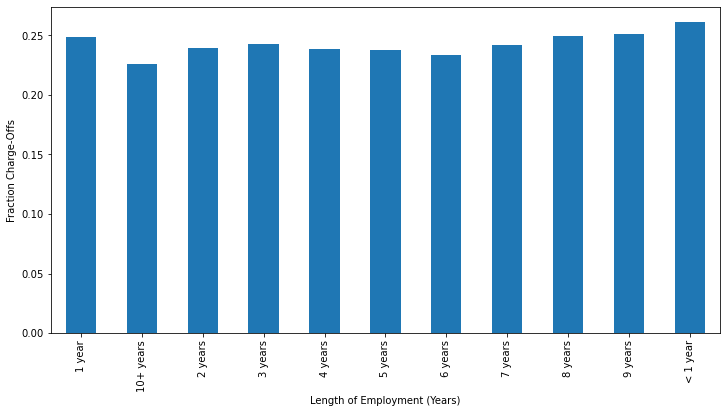

In [20]:
yrs_paid = df[df['loan_paid'] == 1].groupby('emp_length').count()['loan_paid']
yrs_not_paid = df[df['loan_paid'] == 0].groupby('emp_length').count()['loan_paid']
yrs_pct_paid = yrs_not_paid/yrs_paid

plt.figure(figsize=(12, 6))
yrs_pct_paid.plot(kind='bar')
plt.xlabel('Length of Employment (Years)')
plt.ylabel('Fraction Charge-Offs')

It seems that length of employment really doesn't affect the likelihood of a charge-off (notice y-scale range $[.225, .26]$), so this doesn't seem to be important.  We will exclude this feature.

In [21]:
df.drop('emp_length', axis=1, inplace=True)

In [22]:
df['home_ownership'].replace(to_replace=['NONE', 'ANY'], value='OTHER', inplace=True)
df['home_ownership'].unique()

array(['RENT', 'MORTGAGE', 'OWN', 'OTHER'], dtype=object)

<AxesSubplot:xlabel='home_ownership', ylabel='count'>

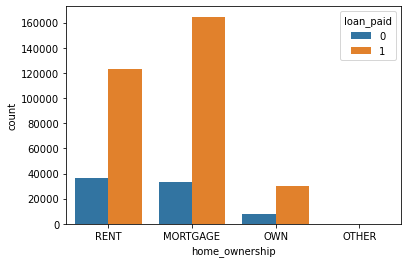

In [23]:
sns.countplot(data=df, x='home_ownership', hue='loan_paid')

Since there are so few instances of other, I think it's fair to have combined 'NONE' and 'OTHER' into that feature.

In [24]:
home_stat = pd.get_dummies(df['home_ownership'].apply(lambda x: x.lower()), prefix='home')
home_stat.sum()
df = df.join(home_stat.drop('home_other', axis=1))
df.drop('home_ownership', axis=1, inplace=True)

In [25]:
df['verification_status'].unique()

array(['Not Verified', 'Source Verified', 'Verified'], dtype=object)

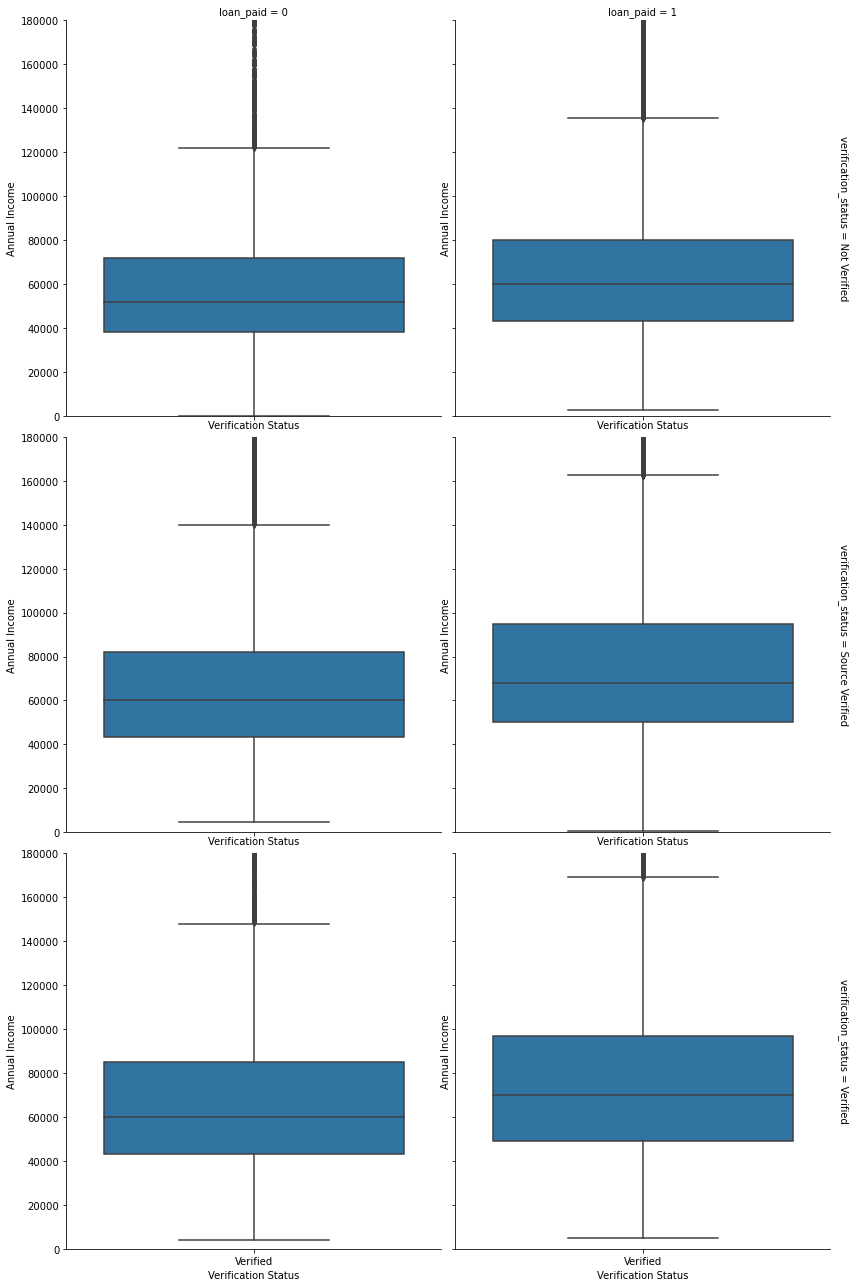

In [26]:
g = sns.FacetGrid(data=df[['loan_paid', 'verification_status', 'annual_inc']],
                    row='verification_status',
                    col='loan_paid',
                    height=6,
                    ylim=(0, 180000),
                    margin_titles=True)
g.map(sns.boxplot, 'verification_status', 'annual_inc')
g.set(xlabel='Verification Status', ylabel='Annual Income')

Please note that in the set of box plots, many outliers are not shown, in order to be able to compare the different shapes of the distributions of annual income with respect to the verification status and if the loan is paid in full.

All data will still be considered in the Machine Learning model, this just allows us to visualize the data more clearly.

<AxesSubplot:xlabel='verification_status', ylabel='count'>

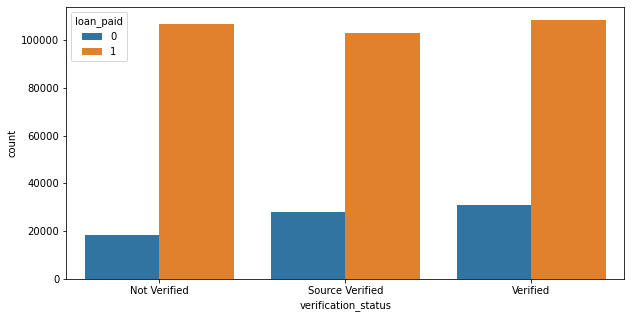

In [27]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='verification_status', hue='loan_paid')

There are two things that I notice here, but are not anything too striking.  Firstly, higher incomes are more likely to be verified, but this doesn't help us predict if a person will fail to pay back the loan in full.  Secondly, we see with the bar graph that the liklihood of not paying the loan back in full increases if the income is verified.  I suspect this is because people that the LendingClub deemed to be higher risk were more thoroughly checked.  



In [28]:
df = df.join(pd.get_dummies(data=df['verification_status'].apply(lambda x: x.lower()), drop_first=True))
df['source_verified'] = df['source verified']
df.drop(['verification_status', 'source verified'], axis=1, inplace=True)

In [29]:
# This is a good plot but causes this file to become too unwieldy when shown
'''
g = sns.FacetGrid(data=df[['annual_inc', 'loan_amnt', 'loan_paid']],
                    col='loan_paid',
                    height=5,
                    )
g.map(sns.scatterplot, 'loan_amnt', 'annual_inc')
g.set(xlabel='Loan Amount', ylabel='Annual Income')
'''

"\ng = sns.FacetGrid(data=df[['annual_inc', 'loan_amnt', 'loan_paid']],\n                    col='loan_paid',\n                    height=5,\n                    )\ng.map(sns.scatterplot, 'loan_amnt', 'annual_inc')\ng.set(xlabel='Loan Amount', ylabel='Annual Income')\n"

One thing that is interesting to note, is that income doesn't seem to affect the size of the loan, which surprises me.  Also, this shows that people who don't pay back the loans tend to have a narrower range of income than those that do.

We need to drop the feature 'issue_d' because we are trying to decide if someone will or won't repay a prospective loan, so technically they wouldn't have had the loan issued yet.

In [30]:
purp_dumm = pd.get_dummies(data=df['purpose'].apply(lambda x: x.lower()), drop_first=True)
df = pd.concat([df, purp_dumm], axis=1)

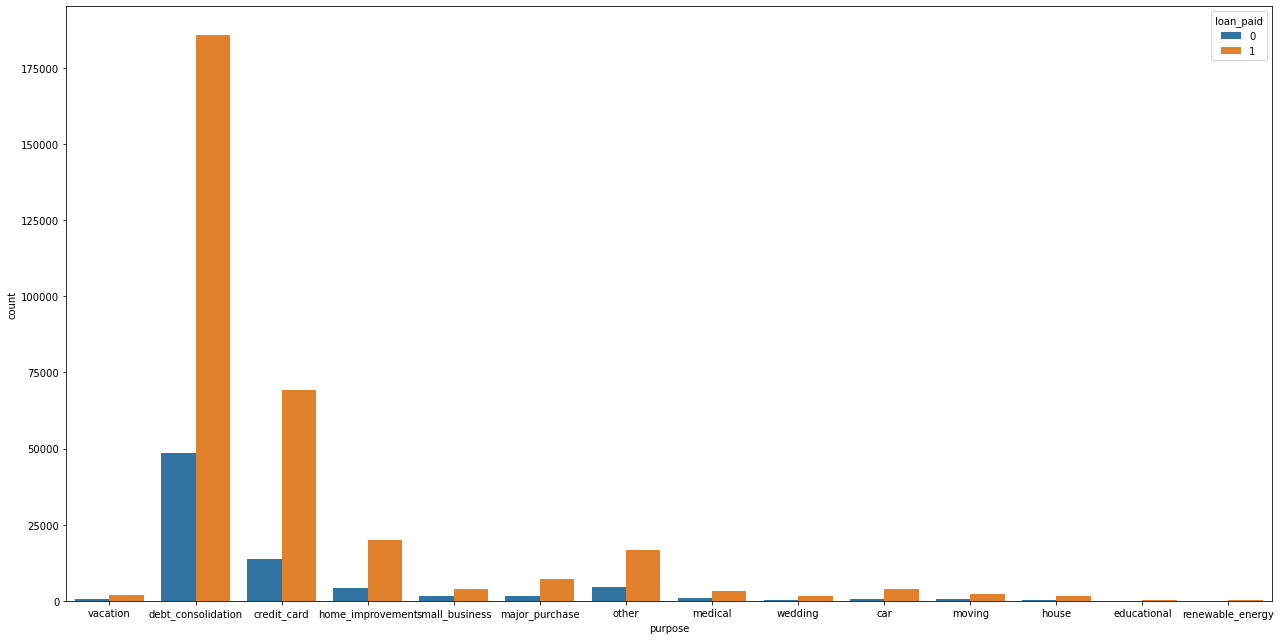

In [31]:
plt.figure(figsize=(18, 9))
sns.countplot(data=df, x='purpose', hue='loan_paid')
plt.tight_layout()

The most common purpose of the loan is for debt consolidation.  It also has a relativelt high chance of failing to have the loan repaid.  There are several others that are high-risk purposes, but this one is the most common.

In [32]:
df.drop('issue_d', axis=1, inplace=True)
df.drop('purpose', axis=1, inplace=True)
df.drop('title', axis=1, inplace=True)

Since 'title' is just the title that the loan is given, and the purpose is already listed, there is no need for this feature.

In [33]:
df['earliest_cr_line'] = df['earliest_cr_line'].apply(lambda x: int(x.split('-')[1]))

In [34]:
df['initial_list_status'] = df['initial_list_status'].apply(lambda x: x.lower())
df['application_type'] = df['application_type'].apply(lambda x: x.lower())
app_n_init = pd.get_dummies(data=df[['initial_list_status', 'application_type']], drop_first=True)
df = pd.concat([df, app_n_init], axis=1)
df.drop(['initial_list_status', 'application_type'], axis=1, inplace=True)

In [35]:
df['address'] = df['address'].apply(lambda x: x.split()[-1])
df = df.join(pd.get_dummies(df['address'], prefix='zip', drop_first=True))
df.drop('address', axis=1, inplace=True)

I find a heatmap of all correlations to be a fun visualization but hard to actually use, so the next plot actually shows useful information.

Text(0.5, 1.0, 'Correlation of Categories to "loan_paid"')

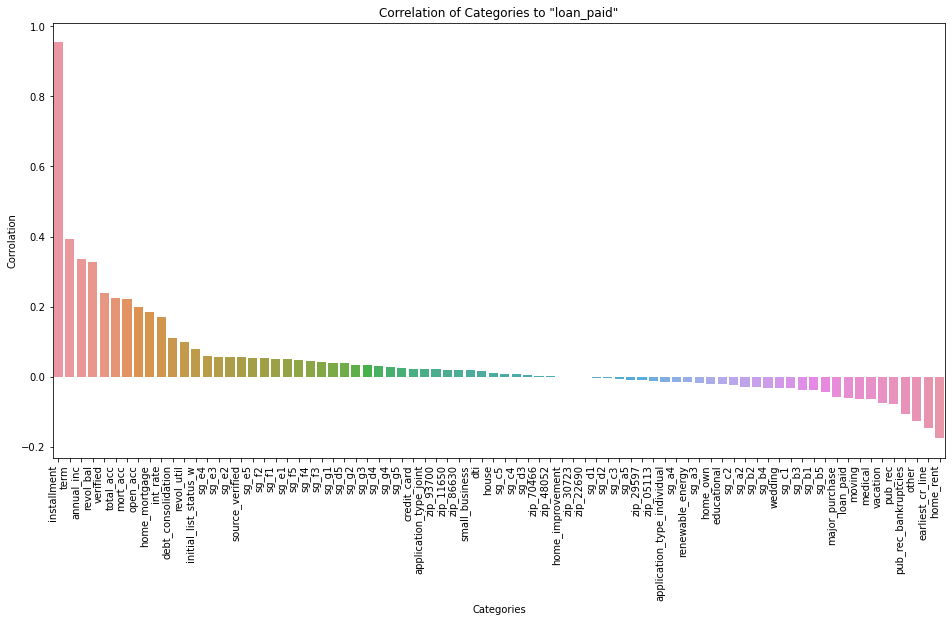

In [36]:
corrs = pd.DataFrame(df.corr()['loan_amnt']).drop('loan_amnt', axis=0).sort_values(by='loan_amnt', ascending=False).reset_index()
plt.figure(figsize=(16, 8))
sns.barplot(data=corrs, x='index', y='loan_amnt')
plt.xticks(rotation=90, horizontalalignment='right')
plt.xlabel('Categories')
plt.ylabel('Corrolation')
plt.title('Correlation of Categories to "loan_paid"')

We can see here that many of the features that have little to no correlation with paying the loan back or not.  There are several with a weak correlation, and one with a strong correlation (installment).

In [37]:
# This is a cool plot to look at but offers no value to the analysis, so will be commented out.
# This is to keep the file from bloating too much
'''
plt.figure(figsize=(10,5))
sns.scatterplot(data=df, x='loan_amnt', y='installment')
'''

"\nplt.figure(figsize=(10,5))\nsns.scatterplot(data=df, x='loan_amnt', y='installment')\n"

It's not surprising at all that the loan amount and the installment amount seem to be highly correlated.

In [38]:
df.columns[df.isnull().any() == True]

Index(['revol_util', 'mort_acc', 'pub_rec_bankruptcies'], dtype='object')

In [39]:
missing_num = df[df.columns[df.isnull().any() == True]].isnull().sum().sort_values(ascending=False)
missing_pct = missing_num/len(df)*100
missing_pct

mort_acc                9.543469
pub_rec_bankruptcies    0.135091
revol_util              0.069692
dtype: float64

In [40]:
df.corr()['mort_acc'].sort_values(ascending=False).head()

mort_acc         1.000000
home_mortgage    0.476730
total_acc        0.381072
annual_inc       0.236320
loan_amnt        0.222315
Name: mort_acc, dtype: float64

The two most highly correlated features are 'home_mortgage' and 'total_acc'.  I will try 

In [41]:
print('home_mortgage: If the person has a mortgage on their house or not')
get_desc('total_acc')
get_desc('mort_acc')

home_mortgage: If the person has a mortgage on their house or not
total_acc: The total number of credit lines currently in the borrower's credit file
mort_acc: Number of mortgage accounts.


In [42]:
mort_acc_means = df[['mort_acc', 'home_mortgage', 'total_acc']].groupby(['home_mortgage', 'total_acc']).mean()
mort_acc_sums = df[['mort_acc', 'home_mortgage', 'total_acc']].groupby(['home_mortgage', 'total_acc']).sum()

In [43]:
mort_acc_means2 = df[['mort_acc', 'total_acc']].groupby('total_acc').mean()
mort_acc_sums2 = df[['mort_acc', 'total_acc']].groupby('total_acc').sum()

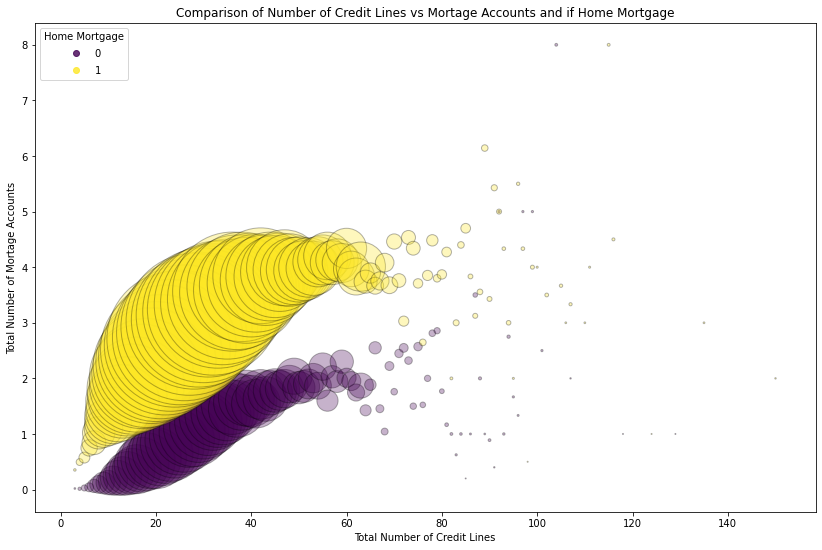

In [44]:
plt.figure(figsize=(14, 9))
scat = plt.scatter(data=mort_acc_means.reset_index(),
            x='total_acc',
            y='mort_acc',
            c='home_mortgage',
            s=mort_acc_sums.reset_index()['mort_acc'],
            alpha=.3,
            edgecolors='black'
            )
plt.xlabel('Total Number of Credit Lines')
plt.ylabel('Total Number of Mortage Accounts')
plt.title('Comparison of Number of Credit Lines vs Mortage Accounts and if Home Mortgage')
handles, labels = scat.legend_elements(prop='colors', alpha=.8)
plt.legend(handles, labels, title='Home Mortgage', loc='upper left')

In [45]:
# This is a useful plot but is the same thing as the first plot, just for total_acc = [0, 65] it is the two lines averaged
# This is commented out to prevent the file from becoming too unwieldy.
'''
plt.figure(figsize=(14, 9))
plt.scatter(data=mort_acc_means2.reset_index(), x='total_acc', y='mort_acc', s=mort_acc_sums2.reset_index()['mort_acc'], alpha=.3, edgecolors='black')
plt.xlabel('Total Number of Credit Lines')
plt.ylabel('Total Number of Mortage Accounts')
plt.title('Comparison of Number of Credit Lines vs Mortage Accounts')
'''

"\nplt.figure(figsize=(14, 9))\nplt.scatter(data=mort_acc_means2.reset_index(), x='total_acc', y='mort_acc', s=mort_acc_sums2.reset_index()['mort_acc'], alpha=.3, edgecolors='black')\nplt.xlabel('Total Number of Credit Lines')\nplt.ylabel('Total Number of Mortage Accounts')\nplt.title('Comparison of Number of Credit Lines vs Mortage Accounts')\n"

This shows a clear separation for the number of mortgage accounts based on both the total number of credit lines and if the person has a home mortgage.  However, we can also see that this clear separation has a lot of values supporting it, while past ~65 total number of credit lines, the number of values per grouping shrinks to much smaller values.  I think the best course of action will be using both features ('total_acc' and 'home_mortgage'), since this creates an extra level of grainularity to our estimation.

In [46]:
mort_acc_means = mort_acc_means.reset_index()

def fill_mort_acc(mort_acc, total_acc, home_mortgage):
    '''
    This function brings in a value from 'mort_acc', and returns the same value if it's not null.  If it is null, a corresponding value is pulled from a premade mean values table depending on the other features 'home_mortgage' and 'total_acc'.

    Ex:
    >> fill_mort_acc(np.nan, 5, 1)
    110    1.149758
    '''
    if pd.isnull(mort_acc):
        return mort_acc_means[
                    (mort_acc_means['home_mortgage'] == home_mortgage) & 
                    (mort_acc_means['total_acc'] == total_acc)
                    ]['mort_acc']
    else:
        return mort_acc

In [47]:
df['mort_acc'] = df.apply(lambda x: fill_mort_acc(x['mort_acc'], x['total_acc'], x['home_mortgage']), axis=1)

Since the last two features that have missing values have less than .2% missing values in the entire rows, these values can all just be dropped.

In [48]:
df.dropna(inplace=True)

---
## Machine Learning
---

In [49]:
# I used this for developing this machine learning model, but chose to use all data points on the final evaluation.
sample_df = df.sample(frac=1, random_state=101)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(sample_df.drop('loan_paid', axis=1).values,
                                        sample_df['loan_paid'].values,
                                        test_size=.3,
                                        random_state=101
                                        )

In [51]:
# This sets aside roughly 10% of data to not be used at all until final evaluation.
X_test, X_val, y_test, y_val = train_test_split(X_test,
                                        y_test,
                                        test_size=.3,
                                        random_state=101
                                        )

In [52]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [53]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [54]:
model = Sequential()

# Input Layer
model.add(Dense(units=len(df.columns), activation='relu'))
model.add(Dropout(.5))

# Hidden Layer
model.add(Dense(units=round(len(df.columns)*3/4), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(units=round(len(df.columns)/2), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(units=round(len(df.columns)/4), activation='relu'))
model.add(Dropout(.5))

# Output Layer
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam')

In [55]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
class_weights = {0: .7, 1: .3}

I chose to weigh the 0 class more heavily because we want to minimize false positives

In [56]:
model.fit(x=X_train,
            y=y_train,
            epochs=500,
            batch_size=1024,
            validation_data=(X_test, y_test),
            verbose=1,
            class_weight=class_weights,
            callbacks=[early_stop]
            )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 276653 samples, validate on 82996 samples
Epoch 1/500
276653/276653 [==============================] - 3s 10us/sample - loss: 0.2391 - val_loss: 0.1551
Epoch 2/500
276653/276653 [==============================] - 2s 8us/sample - loss: 0.1603 - val_loss: 0.1373
Epoch 3/500
276653/276653 [==============================] - 2s 9us/sample - loss: 0.1424 - val_loss: 0.1346
Epoch 4/500
276653/276653 [==============================] - 2s 7us/sample - loss: 0.1370 - val_loss: 0.1323
Epoch 5/500
276653/276653 [==============================] - 2s 7us/sample - loss: 0.1343 - val_loss: 0.1314
Epoch 6/500
276653/276653 [==============================] - 2s 7us/sample - loss: 0.1334 - val_loss: 0.1310
Epoch 7/500
276653/276653 [==============================] - 3s 10us/sample - loss: 0.1322 - val_loss: 0.1302
Epoch 8/500
276653/276653 [==============================] - 2s 8us/sample - loss: 0.1317 - val_loss: 0.1302
Epoch 9/500
276653/276653

<AxesSubplot:>

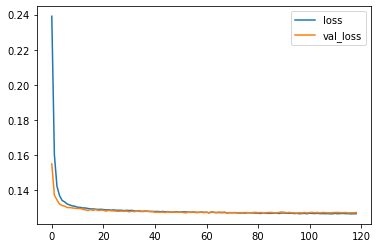

In [57]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

In [58]:
predictions = model.predict_classes(X_val)

In [59]:
print(classification_report(y_val, predictions))
print(confusion_matrix(y_val, predictions))

precision    recall  f1-score   support

           0       0.67      0.64      0.66      6981
           1       0.91      0.92      0.92     28589

    accuracy                           0.87     35570
   macro avg       0.79      0.78      0.79     35570
weighted avg       0.87      0.87      0.87     35570

[[ 4480  2501]
 [ 2186 26403]]


In [60]:
fpr, tpr, _ = roc_curve(y_val, model.predict(X_val))

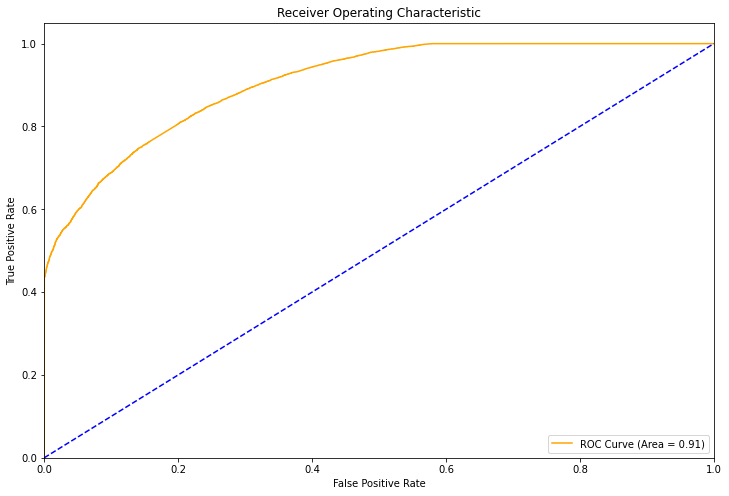

In [61]:
plt.figure(figsize=(12,8))
plt.plot(fpr, tpr, color='orange', label=f'ROC Curve (Area = {round(auc(fpr, tpr), 2)})')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlim([0, 1.])
plt.ylim([0, 1.05])
plt.margins(x=.1, y=.1, tight=False)
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

---
## Application of Model:
---
Task: Given the customer below, would you offer this person a loan?

In [62]:
import random
random.seed(101)
random_ind = random.randint(0,len(df))

new_customer = df.drop('loan_paid',axis=1).iloc[random_ind].values.reshape(1,len(df.columns)-1)
new_customer = scaler.transform(new_customer)

In [63]:
model.predict_classes(new_customer)

array([[0]])

Yes, this model shows that we should provide this customer a loan.

In [64]:
df['loan_paid'].iloc[random_ind]

1

Yes, my model correctly predicted if this customer would pay the loan back.